In [ ]:
# pip install datasketch

In [ ]:
# pip install nearpy

In [3]:
import os
import zipfile
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

In [4]:
# Set  Kaggle API credentials 
os.environ['KAGGLE_USERNAME'] = 'yujata'
os.environ['KAGGLE_KEY'] = '9242ecee1e5f52d323ef6aa903f216e5'

# Dataset URL
dataset_url = 'kazanova/sentiment140'

# Create a Kaggle API instance
api = KaggleApi()
api.authenticate()

# Specify the download path
download_path = './sentiment140_dataset'

if not os.path.exists(download_path):
    os.makedirs(download_path)
    
# Download the dataset
api.dataset_download_files(dataset_url, path=download_path, unzip=True)

In [5]:
# List the files in the downloaded directory
files = os.listdir(download_path)
files

['training.1600000.processed.noemoticon.csv']

In [6]:
# Find the CSV file in the downloaded files
csv_file = [file for file in files if file.endswith('.csv')][0]
csv_file

'training.1600000.processed.noemoticon.csv'

In [7]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(os.path.join(download_path, csv_file), encoding='latin-1', header=None,
                 names=['target', 'id', 'date', 'flag', 'user', 'text'])
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Exploratory Data Analysis

In [8]:
# Extracting timeframe related columns from date column
df['year'] = df['date'].str[-4:]
df['month'] = df['date'].str[4:7]
df["weekday"] = df["date"].str[0:3]

In [9]:
print("Total Records : ",len(df))
print("----------------------------------------------------")
print(df.columns)
print("----------------------------------------------------")
print(df.dtypes)
print("----------------------------------------------------")
print("Unique Records : ")
print(df[["target", "id","user","year","month","weekday"]].nunique())
print("----------------------------------------------------")
print("Unique Month Records : ", df["month"].unique())
print("----------------------------------------------------")
print("Unique Weekday Records : ", df["weekday"].unique())
print("----------------------------------------------------")
print("Unique Values for Target : ", df["target"].unique())
print("The polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)")

Total Records :  1600000
----------------------------------------------------
Index(['target', 'id', 'date', 'flag', 'user', 'text', 'year', 'month',
       'weekday'],
      dtype='object')
----------------------------------------------------
target      int64
id          int64
date       object
flag       object
user       object
text       object
year       object
month      object
weekday    object
dtype: object
----------------------------------------------------
Unique Records : 
target           2
id         1598315
user        659775
year             1
month            3
weekday          7
dtype: int64
----------------------------------------------------
Unique Month Records :  ['Apr' 'May' 'Jun']
----------------------------------------------------
Unique Weekday Records :  ['Mon' 'Tue' 'Fri' 'Sat' 'Sun' 'Wed' 'Thu']
----------------------------------------------------
Unique Values for Target :  [0 4]
The polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)


### Data Cleaning

In [10]:
# Lets look into the duplicate records for id column
duplicate_records = df[df.duplicated(subset='id', keep=False)].sort_values(by='id')
duplicate_records

,target,id,date,flag,user,text,year,month,weekday
213,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...,2009,Apr,Mon
800261,4,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...,2009,Apr,Mon
275,0,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...,2009,Apr,Mon
800300,4,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...,2009,Apr,Mon
989,0,1468053611,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,mariejamora,@hellobebe I also send some updates in plurk b...,2009,Apr,Mon
...,...,...,...,...,...,...,...,...,...
524290,0,2193428118,Tue Jun 16 08:26:44 PDT 2009,NO_QUERY,bubbles00,"finally finished typing!!!! Woohoooo , still ...",2009,Jun,Tue
1599440,4,2193451289,Tue Jun 16 08:28:37 PDT 2009,NO_QUERY,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo...",2009,Jun,Tue
524345,0,2193451289,Tue Jun 16 08:28:37 PDT 2009,NO_QUERY,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo...",2009,Jun,Tue
524688,0,2193576442,Tue Jun 16 08:38:45 PDT 2009,NO_QUERY,emma_b_xox,Had an injection today. Not fun the rrst of t...,2009,Jun,Tue


In [11]:
# Looks like these duplicate id records have 2 values for target, lets verify the same
duplicate_records.groupby("id")["target"].nunique() 

id
1467863684    2
1467880442    2
1468053611    2
1468100580    2
1468115720    2
             ..
2193278017    2
2193403830    2
2193428118    2
2193451289    2
2193576442    2
Name: target, Length: 1685, dtype: int64

In [12]:
# Each duplicated id record has two values for polarity i.e. 0 and 4 indicating they might attribute to mixed sentiments

In [13]:
# Aggregate by id column to get average of target value
df_agg = df.groupby("id")["target"].mean().reset_index(name="avg_target")
df_agg

,id,avg_target
0,1467810369,0.0
1,1467810672,0.0
2,1467810917,0.0
3,1467811184,0.0
4,1467811193,0.0
...,...,...
1598310,2329205009,0.0
1598311,2329205038,0.0
1598312,2329205473,0.0
1598313,2329205574,0.0


In [14]:
# Merge the aggregated dataframe back to the original dataframe
df_merged = df_agg.merge(df[['id', 'date', 'flag', 'user', 'text', 'year', 'month', 'weekday']], on='id', how='left')
# Remove the duplicate records
df_no_duplicates = df_merged.drop_duplicates(subset='id', keep='first')
df_no_duplicates

,id,avg_target,date,flag,user,text,year,month,weekday
0,1467810369,0.0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009,Apr,Mon
1,1467810672,0.0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009,Apr,Mon
2,1467810917,0.0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009,Apr,Mon
3,1467811184,0.0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009,Apr,Mon
4,1467811193,0.0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009,Apr,Mon
...,...,...,...,...,...,...,...,...,...
1599995,2329205009,0.0,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,dandykim,Sick Spending my day laying in bed listening ...,2009,Jun,Thu
1599996,2329205038,0.0,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,bigenya,Gmail is down?,2009,Jun,Thu
1599997,2329205473,0.0,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,LeeLHoke,rest in peace Farrah! So sad,2009,Jun,Thu
1599998,2329205574,0.0,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...,2009,Jun,Thu


### Timeframe Analysis

In [15]:
df_no_duplicates['year_month'] = df['year'] + "-" + df['month']
df_no_duplicates['year_month_wkday'] = df['year'] + "-" + df['month'] + "-" + df["weekday"]

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_1644/3511409458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['year_month'] = df['year'] + "-" + df['month']
/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_1644/3511409458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['year_month_wkday'] = df['year'] + "-" + df['month'] + "-" + df["weekday"]


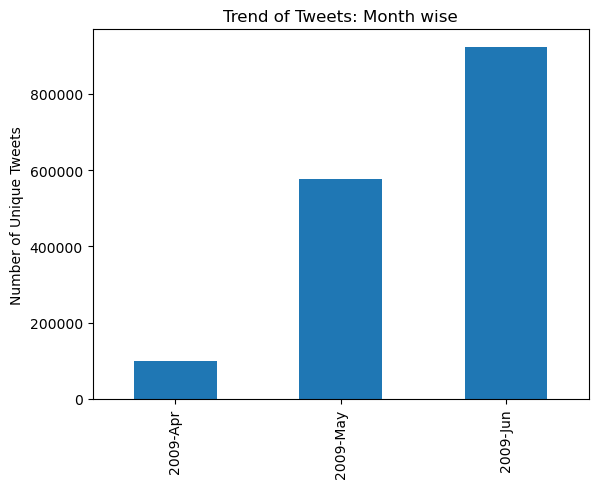

In [16]:
x_order = ["2009-Apr", "2009-May", "2009-Jun"]

# Group by 'year_month' and count unique 'id' values
grouped_data = df_no_duplicates.groupby("year_month")["id"].nunique()

grouped_data[x_order].plot(kind='bar')
plt.title('Trend of Tweets: Month wise')
plt.xlabel("")
plt.ylabel('Number of Unique Tweets')
plt.grid(False)
plt.show()

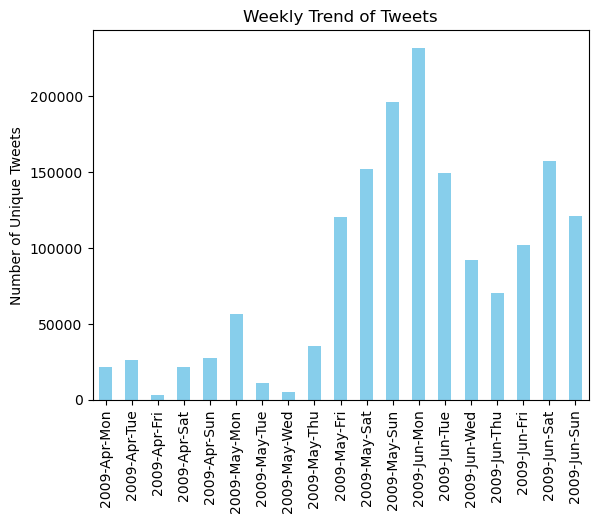

In [17]:
x_wk_order = ["2009-Apr-Mon", "2009-Apr-Tue", "2009-Apr-Fri", "2009-Apr-Sat", "2009-Apr-Sun", "2009-May-Mon","2009-May-Tue","2009-May-Wed",
          "2009-May-Thu","2009-May-Fri","2009-May-Sat","2009-May-Sun","2009-Jun-Mon","2009-Jun-Tue","2009-Jun-Wed",
           "2009-Jun-Thu","2009-Jun-Fri","2009-Jun-Sat","2009-Jun-Sun"]

grouped_data_wk = df_no_duplicates.groupby("year_month_wkday")["id"].nunique()

grouped_data_wk[x_wk_order].plot(kind='bar',color="skyblue")
plt.title('Weekly Trend of Tweets')
plt.xlabel("")
plt.ylabel('Number of Unique Tweets')
plt.grid(False)
plt.show()

#### INSIGHTS

In [18]:
print("# Peak Days:")
print("# The highest count of tweets occurs on Tuesdays in both April and May, with 21794 and 231902 unique tweets, respectively.")
print("# Mondays in May also have a substantial number of tweets, with 101803 unique tweets.")
print()
print("# Weekend Trends:")
print("# Saturdays in May have a high tweet count (149020), indicating increased activity over the weekend.")
print("# Sundays in May follow with a count of 91794 tweets, suggesting continued engagement on weekends.")
print()
print("# Midweek Surge:")
print("# Wednesdays in May show a significant number of tweets (156909), possibly due to midweek discussions or events.")
print()
print("# June Drop:")
print("# The tweet count drops notably in June, with the lowest counts on Sundays (4901) and Saturdays (10769).")
print()
print("# Overall Patterns:")
print("# There seems to be a general trend of increased tweet activity in May compared to April.")
print("# Weekdays generally have higher tweet counts compared to weekends, with Tuesdays and Wednesdays being particularly active.")
print("# Workweek vs. Weekend Dynamics:")
print("# Higher tweet activity on Tuesdays and Wednesdays may be linked to the workweek when people are actively engaging in online discussions and sharing content.")
print("# Increased activity on Mondays and decreased activity on Fridays could be associated with the start and end of the workweek, respectively.")
print()
print("# Weekend Lifestyle:")
print("# Higher tweet counts on Saturdays may be related to weekend activities and events when people have more leisure time for social media.")
print("# Sundays could see continued engagement as users share weekend experiences or prepare for the upcoming week.")

# Peak Days:
# The highest count of tweets occurs on Tuesdays in both April and May, with 21794 and 231902 unique tweets, respectively.
# Mondays in May also have a substantial number of tweets, with 101803 unique tweets.

# Weekend Trends:
# Saturdays in May have a high tweet count (149020), indicating increased activity over the weekend.
# Sundays in May follow with a count of 91794 tweets, suggesting continued engagement on weekends.

# Midweek Surge:
# Wednesdays in May show a significant number of tweets (156909), possibly due to midweek discussions or events.

# June Drop:
# The tweet count drops notably in June, with the lowest counts on Sundays (4901) and Saturdays (10769).

# Overall Patterns:
# There seems to be a general trend of increased tweet activity in May compared to April.
# Weekdays generally have higher tweet counts compared to weekends, with Tuesdays and Wednesdays being particularly active.
# Workweek vs. Weekend Dynamics:
# Higher tweet activity on Tuesdays and W

### Tweet text Analysis using WordCloud Summary

In [19]:
# Function for text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [20]:
# Apply text cleaning to the 'text' column
df_no_duplicates['cleaned_text'] = df_no_duplicates['text'].apply(clean_text)

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_1644/300394518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['cleaned_text'] = df_no_duplicates['text'].apply(clean_text)


In [21]:
# Function to generate word cloud for a specific weekday
def generate_word_cloud(weekday):
    text_data = ' '.join(df_no_duplicates[df_no_duplicates['weekday'] == weekday]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    return wordcloud

# Generate word clouds for different weekdays
unique_weekdays = df_no_duplicates['weekday'].unique()
for weekday in unique_weekdays:
    wordcloud = generate_word_cloud(weekday)
    summary = f"Word Cloud for Weekday = {weekday}:\n{str(wordcloud.words_)}"
    print(summary)

Word Cloud for Weekday = Mon:
{'lol': 1.0, 'love': 0.9109208185053381, 'today': 0.8688834519572953, 'amp': 0.7669039145907474, 'one': 0.7595640569395018, 'thank': 0.7582295373665481, 'u': 0.7525578291814946, 'work': 0.6947286476868327, 'time': 0.6633674377224199, 'got': 0.5774021352313167, 'think': 0.5500444839857651, 'haha': 0.5440391459074733, 'day': 0.5012233096085409, 'still': 0.49877669039145905, 'good': 0.4963300711743772, 'need': 0.48854537366548045, 'gon na': 0.4824288256227758, 'im': 0.4817615658362989, 'well': 0.4777580071174377, 'right': 0.4667482206405694, 'know': 0.44272686832740216, 'oh': 0.44161476868327404, 'though': 0.43104982206405695, 'miss': 0.4179270462633452, 'twitter': 0.4170373665480427, 'going': 0.4071396797153025, 'want': 0.3790035587188612, 'back': 0.37744661921708184, 'thing': 0.37666814946619215, 'wish': 0.373220640569395, 'look': 0.3682161921708185, 'hope': 0.36054270462633453, 'tomorrow': 0.3564279359430605, 'fun': 0.3554270462633452, 'much': 0.3529804270

Word Cloud for Weekday = Fri:
{'lol': 1.0, 'love': 0.9554159186116098, 'today': 0.9201077199281867, 'u': 0.8524835427887493, 'amp': 0.8307899461400359, 'one': 0.8061041292639138, 'thank': 0.7869539198084979, 'im': 0.7250149611011371, 'work': 0.7112507480550568, 'time': 0.6967384799521245, 'got': 0.6524536205864752, 'good': 0.5532615200478755, 'think': 0.5445840813883902, 'day': 0.535607420706164, 'gon na': 0.5197486535008977, 'well': 0.5169060442848593, 'haha': 0.505834829443447, 'tonight': 0.5046379413524835, 'still': 0.4967085577498504, 'need': 0.49042489527229205, 'know': 0.48758228605625376, 'miss': 0.4756134051466188, 'right': 0.47127468581687615, 'going': 0.456163973668462, 'twitter': 0.4557151406343507, 'wish': 0.44853381208856974, 'dont': 0.43970676241771395, 'want': 0.4322262118491921, 'though': 0.42624177139437464, 'tomorrow': 0.4228007181328546, 'fun': 0.41921005385996407, 'oh': 0.414721723518851, 'friend': 0.4063435068821065, 'back': 0.4018551765409934, 'look': 0.3873429084

Word Cloud for Weekday = Sun:
{'lol': 1.0, 'love': 0.9778982485404504, 'today': 0.8865721434528774, 'amp': 0.8572768974145121, 'one': 0.7567764804003336, 'u': 0.7492702251876564, 'thank': 0.7200792326939116, 'time': 0.6871351125938282, 'got': 0.5991451209341118, 'haha': 0.5979983319432861, 'work': 0.5540033361134279, 'think': 0.5499374478732277, 'gon na': 0.5136572143452878, 'well': 0.5015638031693077, 'good': 0.48696830692243537, 'still': 0.48071309424520436, 'need': 0.4745621351125938, 'right': 0.47112176814011675, 'im': 0.4499582985821518, 'going': 0.43286071726438696, 'oh': 0.42483319432860717, 'though': 0.4233736447039199, 'know': 0.41201000834028356, 'twitter': 0.4109674728940784, 'fun': 0.4103419516263553, 'miss': 0.4103419516263553, 'friend': 0.3846955796497081, 'great': 0.3839658048373645, 'wish': 0.3829232693911593, 'look': 0.36895329441201, 'want': 0.3670767306088407, 'thing': 0.36426188490408673, 'make': 0.3560258548790659, 'last night': 0.35018765638031696, 'nice': 0.34883

Word Cloud for Weekday = Thu:
{'today': 1.0, 'im': 0.9343962362780972, 'work': 0.8758494511238892, 'u': 0.7869837950862519, 'lol': 0.7859383167799269, 'one': 0.7676424464192368, 'got': 0.713800313643492, 'day': 0.7059592263460533, 'love': 0.6923680083638265, 'time': 0.6826973340303188, 'amp': 0.6186617877679038, 'miss': 0.5616832200731835, 'still': 0.5559330893883951, 'good': 0.5548876110820701, 'need': 0.5399895452169368, 'think': 0.514636696288552, 'dont': 0.4939884997386304, 'wish': 0.4921589127025614, 'thank': 0.49163617354939887, 'going': 0.4856246732880293, 'want': 0.48248823836905386, 'well': 0.47987454260324097, 'know': 0.4547830632514375, 'right': 0.4539989545216937, 'oh': 0.4508625196027182, 'back': 0.4430214323052797, 'gon na': 0.4375326711970727, 'tomorrow': 0.43204391008886567, 'hate': 0.43047569262937796, 'cant': 0.4069524307370622, 'though': 0.39884997386304233, 'much': 0.3962362780972295, 'haha': 0.39492943021432303, 'tonight': 0.3928384736016728, 'twitter': 0.386565603

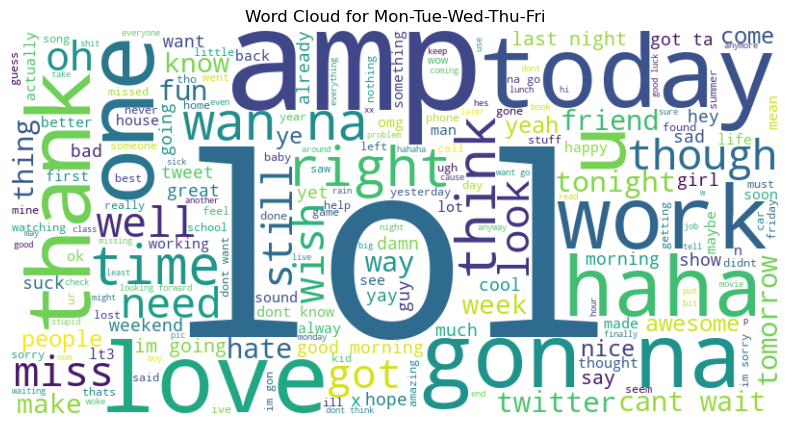

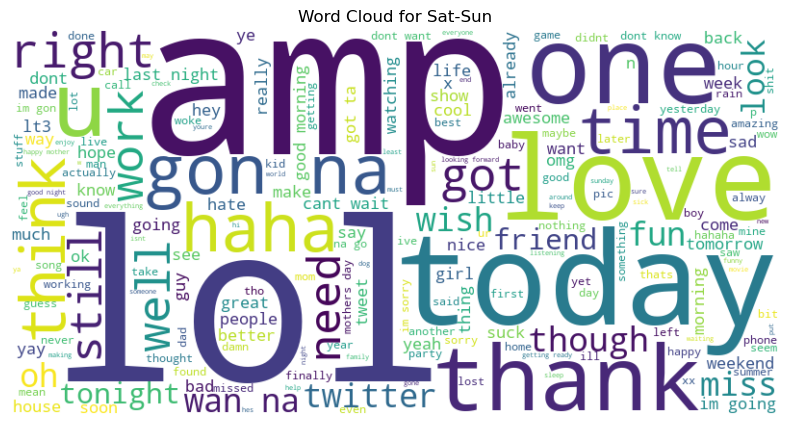

In [22]:
# Function to generate word cloud for a specific day type (weekday or weekend)
def generate_word_cloud(day_type):
    text_data = ' '.join(df_no_duplicates[df_no_duplicates['weekday'].isin(day_type)]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for {}'.format('-'.join(day_type)))
    plt.show()

# Split the DataFrame into weekdays and weekends
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
weekends = ['Sat', 'Sun']

# Generate word clouds for weekdays and weekends
generate_word_cloud(weekdays)
generate_word_cloud(weekends)

In [23]:
# Function to generate word cloud for a specific avg_target value
def generate_word_cloud(avg_target_value):
    text_data = ' '.join(df_no_duplicates[df_no_duplicates['avg_target'] == avg_target_value]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    return wordcloud

# Generate word clouds for different average target values
unique_avg_targets = df_no_duplicates['avg_target'].unique()
for avg_target_value in unique_avg_targets:
    wordcloud = generate_word_cloud(avg_target_value)
    summary = f"Word Cloud for Average Target = {avg_target_value}:\n{str(wordcloud.words_)}"
    print(summary)


Word Cloud for Average Target = 0.0:
{'today': 1.0, 'lol': 0.9859089398471252, 'amp': 0.9391824526420738, 'gon na': 0.8615486872715188, 'one': 0.8499169159189099, 'wan na': 0.782917912927883, 'wish': 0.7615819209039548, 'work': 0.7181787969425059, 'though': 0.6662013958125623, 'miss': 0.615819209039548, 'need': 0.6089066134928548, 'hate': 0.6059155865736124, 'u': 0.6049185776005317, 'love': 0.6039880358923231, 'time': 0.6027916251246261, 'still': 0.6021934197407777, 'right': 0.5954137587238285, 'think': 0.5715520106347624, 'got': 0.5290794283815221, 'look': 0.5101362578929877, 'oh': 0.5096045197740113, 'last night': 0.4880026586905949, 'tonight': 0.4773678963110668, 'haha': 0.4761714855433699, 'well': 0.4759056164838817, 'sad': 0.47570621468926555, 'thing': 0.4706547025589897, 'bad': 0.4681289464938518, 'twitter': 0.45310734463276836, 'suck': 0.4371552010634762, 'much': 0.4327683615819209, 'damn': 0.4280491857760053, 'friend': 0.4140910601528747, 'week': 0.3943502824858757, 'tomorrow':

Word Cloud for Average Target = 2.0:
{'im': 1.0, 'day': 0.6103896103896104, 'today': 0.5411255411255411, 'back': 0.4805194805194805, 'lol': 0.47186147186147187, 'though': 0.4675324675324675, 'work': 0.43722943722943725, 'got': 0.43722943722943725, 'u': 0.42857142857142855, 'go': 0.41125541125541126, 'love': 0.3939393939393939, 'good': 0.38961038961038963, 'see': 0.37662337662337664, 'time': 0.36796536796536794, 'tomorrow': 0.36796536796536794, 'dont': 0.354978354978355, 'well': 0.329004329004329, 'school': 0.3246753246753247, 'really': 0.3116883116883117, 'ill': 0.30735930735930733, 'one': 0.2987012987012987, 'still': 0.2987012987012987, 'miss': 0.2943722943722944, 'cant': 0.2943722943722944, 'hope': 0.29004329004329005, 'going': 0.29004329004329005, 'new': 0.27705627705627706, 'home': 0.24675324675324675, 'know': 0.24242424242424243, 'haha': 0.23376623376623376, 'oh': 0.22510822510822512, 'bad': 0.22510822510822512, 'week': 0.22077922077922077, 'think': 0.22077922077922077, 'amp': 0.2

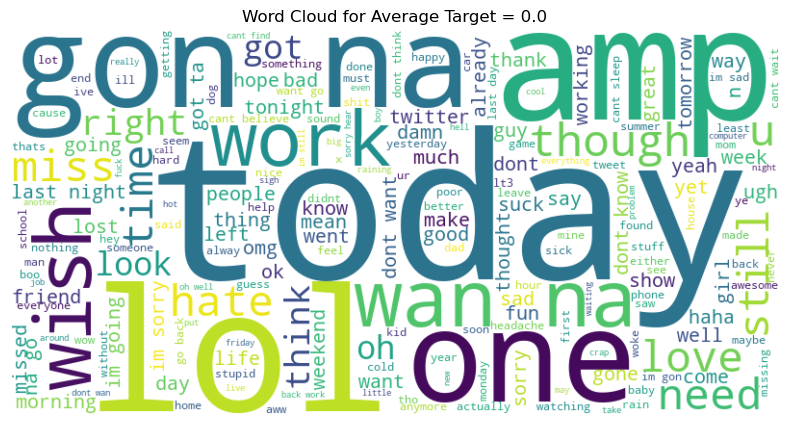

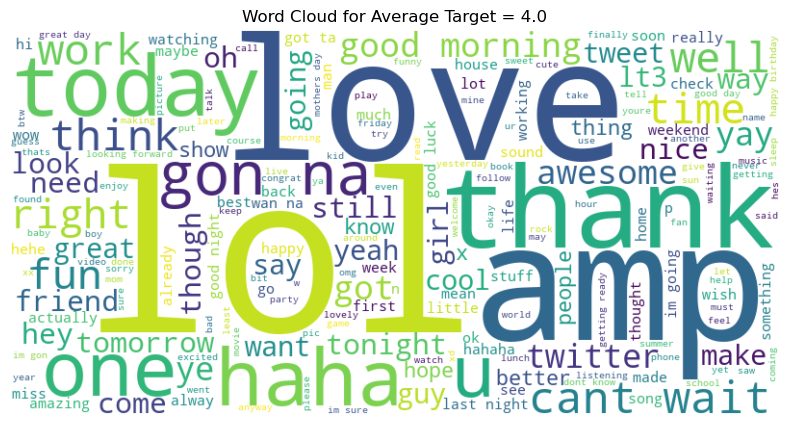

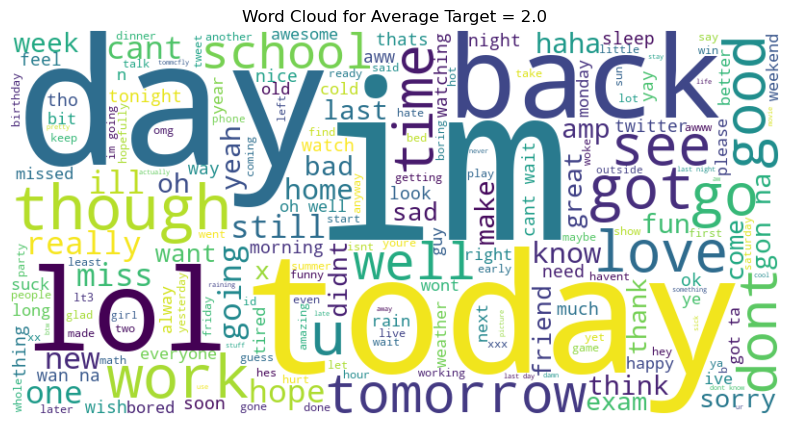

In [24]:
# Function to generate and plot word cloud for a specific avg_target value
def generate_and_plot_word_cloud(avg_target_value):
    text_data = ' '.join(df_no_duplicates[df_no_duplicates['avg_target'] == avg_target_value]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Average Target = {avg_target_value}')
    plt.show()

# Generate and plot word clouds for different average target values
unique_avg_targets = df_no_duplicates['avg_target'].unique()
for avg_target_value in unique_avg_targets:
    generate_and_plot_word_cloud(avg_target_value)

#### INSIGHTS

In [25]:
print("# Negative Sentiment (Average Target = 0.0):")
print("# Common Negative Keywords: hate, miss, suck, damn, bad, sorry, ugh, stupid, shit, sick.")
print("# Context: Users expressing negative emotions, dissatisfaction, and frustration. Negative experiences and challenges are highlighted, such as hating, missing things, feeling sick, and having a bad day.")
print()
print("# Neutral Sentiment (Average Target = 2.0):")
print("# Common Neutral Keywords: day, today, work, time, tomorrow, school, know, well, good, see.")
print("# Context: Users discussing their daily activities, work, and general events without a strong positive or negative sentiment. Neutral and factual statements about the day, time, and plans are prevalent.")
print()
print("# Positive Sentiment (Average Target = 4.0):")
print("# Common Positive Keywords: love, thank, today, haha, awesome, fun, great, yay, nice, happy.")
print("# Context: Users expressing positive emotions, gratitude, and excitement. Positive experiences, enjoyable moments, and happy feelings are conveyed. The use of words like 'love,' 'thank,' and 'awesome' suggests a positive outlook.")
print()
print("# Cross-Sentiment Insights:")
print("# Common Keywords Across Sentiments: today, lol, work, time, still, right, think, got, look, oh, tonight, well, week, tomorrow, morning, people, fun, already, want, know, yeah, good, going, show, weekend, thank, say, hope.")
print("# Context: Certain words appear across all sentiment levels, indicating shared experiences and common topics. These include discussions about the day, work, time, events, and expressions of hope and gratitude.")

# Negative Sentiment (Average Target = 0.0):
# Common Negative Keywords: hate, miss, suck, damn, bad, sorry, ugh, stupid, shit, sick.
# Context: Users expressing negative emotions, dissatisfaction, and frustration. Negative experiences and challenges are highlighted, such as hating, missing things, feeling sick, and having a bad day.

# Neutral Sentiment (Average Target = 2.0):
# Common Neutral Keywords: day, today, work, time, tomorrow, school, know, well, good, see.
# Context: Users discussing their daily activities, work, and general events without a strong positive or negative sentiment. Neutral and factual statements about the day, time, and plans are prevalent.

# Positive Sentiment (Average Target = 4.0):
# Common Positive Keywords: love, thank, today, haha, awesome, fun, great, yay, nice, happy.
# Context: Users expressing positive emotions, gratitude, and excitement. Positive experiences, enjoyable moments, and happy feelings are conveyed. The use of words like 'love,' 'thank,

### URL Analysis

In [26]:
# Define a function to extract URLs using a regular expression
def extract_urls(text):
    url_pattern = r'https?://\S+'
    urls = re.findall(url_pattern, text)
    return urls

# Apply the function to the 'cleaned_text' column and create a new 'urls' column
df_no_duplicates['urls'] = df_no_duplicates['text'].apply(extract_urls)

# Explode the 'urls' column to create a new row for each URL
df_new = df_no_duplicates.explode('urls')

/var/folders/ld/q1czxsbd2fl10zwy_z_flk3h0000gn/T/ipykernel_1644/3362810952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['urls'] = df_no_duplicates['text'].apply(extract_urls)


In [27]:
# Perform groupby and aggregation
url_agg = df_new.groupby("urls")["id"].unique().reset_index(name='id')

# Define the patterns to filter
url_patterns_to_drop = ["http://'", "http://..", "http://...","http://&quot;","http://',"]

# Filter and drop records based on the specified patterns
df_url_filtered = url_agg[~url_agg['urls'].isin(url_patterns_to_drop)]

# Top 50 urls
df_url_filtered.head(50)

,urls,id
4,http:///www.playspymaster.com.,[1982612743]
5,http://0845.com,"[2001926757, 2009051563, 2175781155]"
6,http://0rz.tw/7ESci,[2015127419]
7,http://0rz.tw/hQVpC,[1793180377]
8,http://1000awesomethings.com/,[2188362391]
9,http://100wpd.com,[1684843548]
10,http://101coloringpages.com,[1685425242]
11,http://11870.com/pro/este-o-este,[1835034485]
12,http://11bwife.blogspot.com/,[2189902413]
13,http://12gi.tumblr.com,[2174440886]


#### INSIGHTS

In [28]:
# Summarized information
summary = "The list of top 50 URLs from various tweets reflects a diverse range of content, including games, social/n  media metrics, blogs, art, science, and entertainment."
print("Summary:",summary)

# Additional details about domain popularity
popularity_info = "Some domains appear frequently, indicating their popularity."
print("Popularity Info:", popularity_info)

# Mention of shortened URLs
shortened_urls_info = "Shortened URLs are common, suggesting the influence of character limits on platforms like Twitter."
print("Shortened URLs:",shortened_urls_info)

# Diverse content types
content_types_info = "The content spans personal expression, technical/scientific references, and promotional activities."
print("Content Types:",content_types_info)

# Repetition of certain URLs
repetition_info = "The repetition of certain URLs hints at campaigns or sustained interest."
print("Repetition:",repetition_info)

# Need for additional context
context_info = "Additional context, such as tweet content and user demographics, would provide more insights into the/n  reasons behind the popularity of these links."
print("Context :",context_info)

Summary: The list of top 50 URLs from various tweets reflects a diverse range of content, including games, social/n  media metrics, blogs, art, science, and entertainment.
Popularity Info: Some domains appear frequently, indicating their popularity.
Shortened URLs: Shortened URLs are common, suggesting the influence of character limits on platforms like Twitter.
Content Types: The content spans personal expression, technical/scientific references, and promotional activities.
Repetition: The repetition of certain URLs hints at campaigns or sustained interest.
Context : Additional context, such as tweet content and user demographics, would provide more insights into the/n  reasons behind the popularity of these links.


## TWEET SIMILARITY AND DUPLICATION ANALYSIS : JACCARD DISTANCE

In [29]:
df_tweet = pd.DataFrame(df_no_duplicates["text"])

In [30]:
# Function to clean text, remove URLs, and limit the length
def clean_text(text, min_words=3, max_words=10):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Limit the length of the text to be between min_words and max_words
    words = text.split()
    if len(words) < min_words:
        text = ' '.join(words[:min_words])
    elif len(words) > max_words:
        text = ' '.join(words[:max_words])
    return text

# Apply text cleaning to the 'text' column
df_tweet['cleaned_text'] = df_tweet['text'].apply(clean_text)

In [31]:
# Jaccard distance is a measure of dissimilarity between two sets, often used to quantify the dissimilarity between 
# two text documents. 
# It is calculated as the size of the intersection of the sets divided by the size of the union of the sets. 
# In the context of text analysis, the sets represent the unique elements (e.g., words) present in each document.

In [32]:
# Function to calculate Jaccard similarity
def jaccard_similarity(str1, str2):
    if str1 is None or str2 is None:
        return 0.0  # Handle cases where one or both inputs are None
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Apply text cleaning to the 'text' column and store the result in the 'cleaned_text' column
df_tweet['cleaned_text'] = df_tweet['text'].apply(clean_text)

In [33]:
# Function to count unique and duplicate pairs based on Jaccard distance threshold
def count_pairs(df, threshold):
    df['cleaned_text_ref'] = df['cleaned_text'].shift(1)
    df['jaccard_similarity'] = df.apply(lambda row: jaccard_similarity(row['cleaned_text'], row['cleaned_text_ref']), axis=1)
    
    # Filter rows based on Jaccard distance threshold
    result_df = df[df['jaccard_similarity'] <= 1 - threshold]

    # Count unique and duplicate pairs
    unique_pairs = result_df.drop_duplicates(subset=['cleaned_text', 'cleaned_text_ref'])
    duplicate_pairs = result_df[result_df.duplicated(subset=['cleaned_text', 'cleaned_text_ref'], keep=False)]

    return len(unique_pairs), len(duplicate_pairs)


# Apply text cleaning to the 'text' column and store the result in the 'cleaned_text' column
df_tweet['cleaned_text'] = df_tweet['text'].apply(clean_text)

In [34]:
# Specify thresholds
thresholds = [0.3, 0.5, 0.7]

# Create a list to store results for each threshold
results_list = []

# Create separate tables for each threshold
for threshold in thresholds:
    unique_count, duplicate_count = count_pairs(df_tweet, threshold)

    # Create a DataFrame for each threshold
    results_df = pd.DataFrame({
        'Category': ['Unique Pairs', 'Duplicate Pairs'],
        'Count': [unique_count, duplicate_count]
    })
    
    # Print the table for the current threshold
    print(f'Threshold: {threshold}')
    print(results_df)
    print('\n')

    # Append the DataFrame to the results list
    results_list.append(results_df)

Threshold: 0.3
          Category    Count
0     Unique Pairs  1597744
1  Duplicate Pairs      163


Threshold: 0.5
          Category    Count
0     Unique Pairs  1597693
1  Duplicate Pairs      163


Threshold: 0.7
          Category    Count
0     Unique Pairs  1597221
1  Duplicate Pairs        8


